# Diffusion Models

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def sample_gaussian_mixture(batch_size):
    # Two Gaussians with means -2 and +2, same variance
    means = torch.tensor([-2.0, 2.0]).to(device)
    # Randomly choose one of the 2 components
    idx = torch.randint(0, 2, (batch_size,))
    chosen_mean = means[idx].unsqueeze(1)
    # Standard deviation of 0.5
    samples = chosen_mean + 0.5 * torch.randn(batch_size, 1).to(device)
    return samples

In [16]:
from DDPM import SimpleDiffusionModel

T = 1000
beta_start = 1e-4
beta_end = 0.02

betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

model = SimpleDiffusionModel(T).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

num_epochs = 10000
batch_size = 128

In [17]:
for epoch in range(num_epochs):
    model.train()
    # Sample from the toy Gaussian mixture
    x0 = sample_gaussian_mixture(batch_size)  # shape [batch, 1]

    # Randomly select a diffusion time-step for each sample in the batch
    t = torch.randint(0, T, (batch_size,), device=device)

    # For each sample, get the corresponding alpha_cumprod and noise variance
    a_cumprod_t = alphas_cumprod[t].unsqueeze(1)  # [batch, 1]

    # Sample noise to add
    noise = torch.randn_like(x0)

    # The forward process: x_t = sqrt(alpha_cumprod) * x0 + sqrt(1 - alpha_cumprod) * noise
    sqrt_a_cumprod = torch.sqrt(a_cumprod_t)
    sqrt_one_minus_a_cumprod = torch.sqrt(1 - a_cumprod_t)
    x_t = sqrt_a_cumprod * x0 + sqrt_one_minus_a_cumprod * noise

    # The target is the noise added
    noise_target = noise

    # Predict the noise with the model conditioned on x_t and t
    noise_pred = model(x_t, t)

    loss = loss_fn(noise_pred, noise_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f}")

Epoch 0: Loss 0.8744
Epoch 500: Loss 0.6637
Epoch 1000: Loss 0.3155
Epoch 1500: Loss 0.2710
Epoch 2000: Loss 0.5155
Epoch 2500: Loss 0.3159
Epoch 3000: Loss 0.3600
Epoch 3500: Loss 0.3150
Epoch 4000: Loss 0.3605
Epoch 4500: Loss 0.3026
Epoch 5000: Loss 0.4614
Epoch 5500: Loss 0.1843
Epoch 6000: Loss 0.2790
Epoch 6500: Loss 0.3216
Epoch 7000: Loss 0.2501
Epoch 7500: Loss 0.3015
Epoch 8000: Loss 0.1786
Epoch 8500: Loss 0.3134
Epoch 9000: Loss 0.2764
Epoch 9500: Loss 0.2929


In [18]:
@torch.no_grad()
def sample_ddpm_stable(model, num_samples=1000):
    """
    Generate samples using the reverse diffusion process with added clamping
    for numerical stability.

    Args:
        model: The trained diffusion model.
        num_samples: Number of samples to generate.

    Returns:
        Tensor of generated samples.
    """
    model.eval()
    x_t = torch.randn(num_samples, 1).to(device)

    for t_inv in reversed(range(T)):
        t_val = torch.full((num_samples,), t_inv, device=device, dtype=torch.long)
        noise_pred = model(x_t, t_val)

        # Get alpha cumulative product for current timestep and clamp for safety
        a_cumprod = alphas_cumprod[t_inv]
        a_cumprod = torch.clamp(a_cumprod, min=1e-7, max=1.0)
        sqrt_a_cumprod = torch.sqrt(a_cumprod)
        sqrt_one_minus_a_cumprod = torch.sqrt(torch.clamp(1 - a_cumprod, min=1e-7))

        # Estimate the original x0
        x0_pred = (x_t - sqrt_one_minus_a_cumprod * noise_pred) / sqrt_a_cumprod
        # Clamp x0_pred to prevent extreme values
        x0_pred = torch.clamp(x0_pred, -10.0, 10.0)

        # Update x_t based on the reverse diffusion formula
        if t_inv > 0:
            a_t = alphas[t_inv]
            beta_t = betas[t_inv]
            a_t = torch.clamp(a_t, min=1e-7, max=1.0)
            beta_t = torch.clamp(beta_t, min=1e-7, max=1.0)

            noise = torch.randn_like(x_t)
            x_t = torch.sqrt(a_t) * x0_pred + torch.sqrt(beta_t) * noise
        else:
            x_t = x0_pred

        # Check for any NaN values and clamp if necessary.
        if torch.isnan(x_t).any():
            print(f"Warning: NaNs encountered at step {t_inv}, clamping values.")
            x_t = torch.clamp(x_t, -10.0, 10.0)

    return x_t

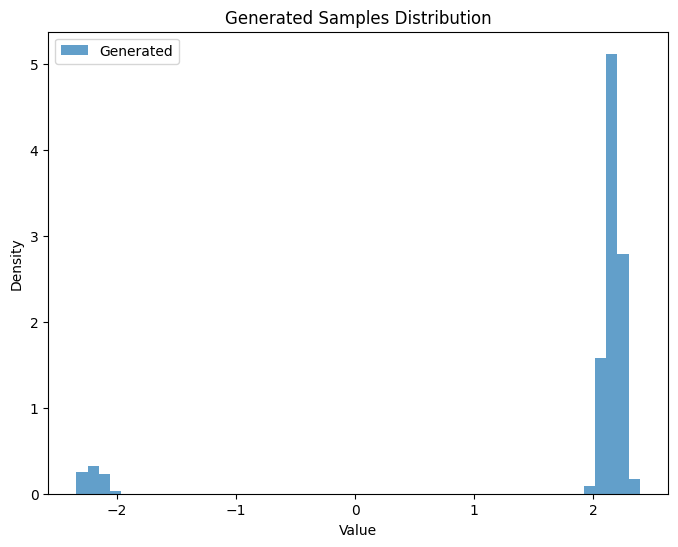

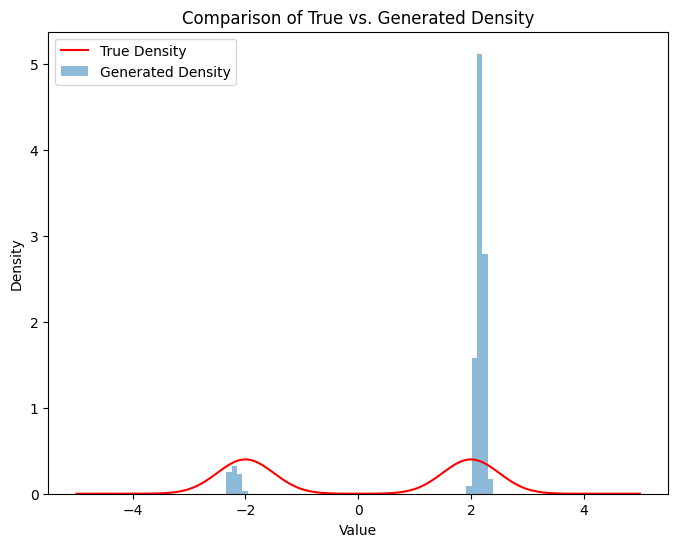

In [19]:
# Generate samples
samples = sample_ddpm_stable(model, num_samples=1000).cpu().numpy()

# Plot a histogram of the generated samples
plt.figure(figsize=(8, 6))
plt.hist(samples, bins=50, density=True, alpha=0.7, label='Generated')
plt.title("Generated Samples Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Also, plot the original Gaussian mixture for reference.
# Plot PDF for mixture of two Gaussians with means -2 and +2, std=0.5 each.
xs = np.linspace(-5, 5, 200)
pdf = 0.5 * (1 / (0.5 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xs + 2) / 0.5) ** 2) + \
      0.5 * (1 / (0.5 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xs - 2) / 0.5) ** 2)
plt.figure(figsize=(8, 6))
plt.plot(xs, pdf, label='True Density', color='red')
plt.hist(samples, bins=50, density=True, alpha=0.5, label='Generated Density')
plt.title("Comparison of True vs. Generated Density")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()